# Cargo las imágenes de google drive

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/COQ-ESC-UCN/Projects/2022/Personal

Mounted at /gdrive
/gdrive/MyDrive/COQ-ESC-UCN/Projects/2022/Personal


In [2]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

img = cv2.imread('El_ejemplo_de_Cedula_identidad_Chile_2013.jpg')

# Cambio de espacio de color de BGR a RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Cambio de espacio de color BGR a GRAY
gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)

# Ecualización
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
rut_eq = clahe.apply(gray)

# Binarización
ret,rut_bin = cv2.threshold(rut_eq,127,255,cv2.THRESH_BINARY)

# Binarización otsu
ret2,rut_otsu = cv2.threshold(rut_eq, 127,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

In [3]:
import matplotlib.pyplot as plt

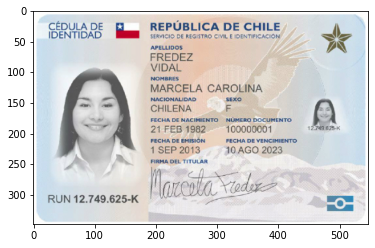

In [4]:
plt.imshow(img_rgb)

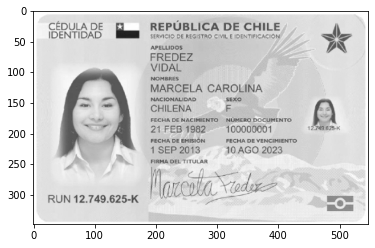

In [5]:
plt.imshow(gray, cmap='gray', vmin=0, vmax=255)

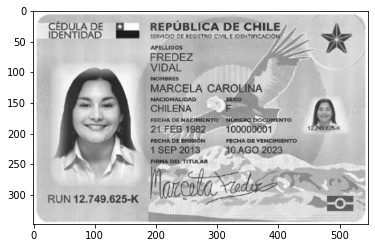

In [6]:
plt.imshow(rut_eq, cmap='gray', vmin=0, vmax=255)

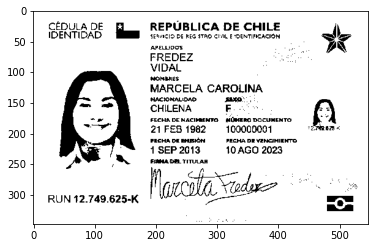

In [7]:
plt.imshow(rut_bin, cmap='gray', vmin=0, vmax=255)

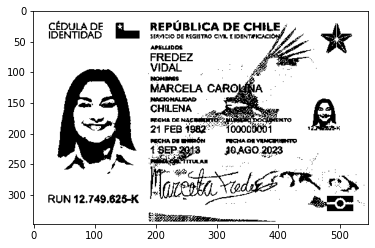

In [8]:
plt.imshow(rut_otsu, cmap='gray', vmin=0, vmax=255)

# Calcular los descriptores SIFT

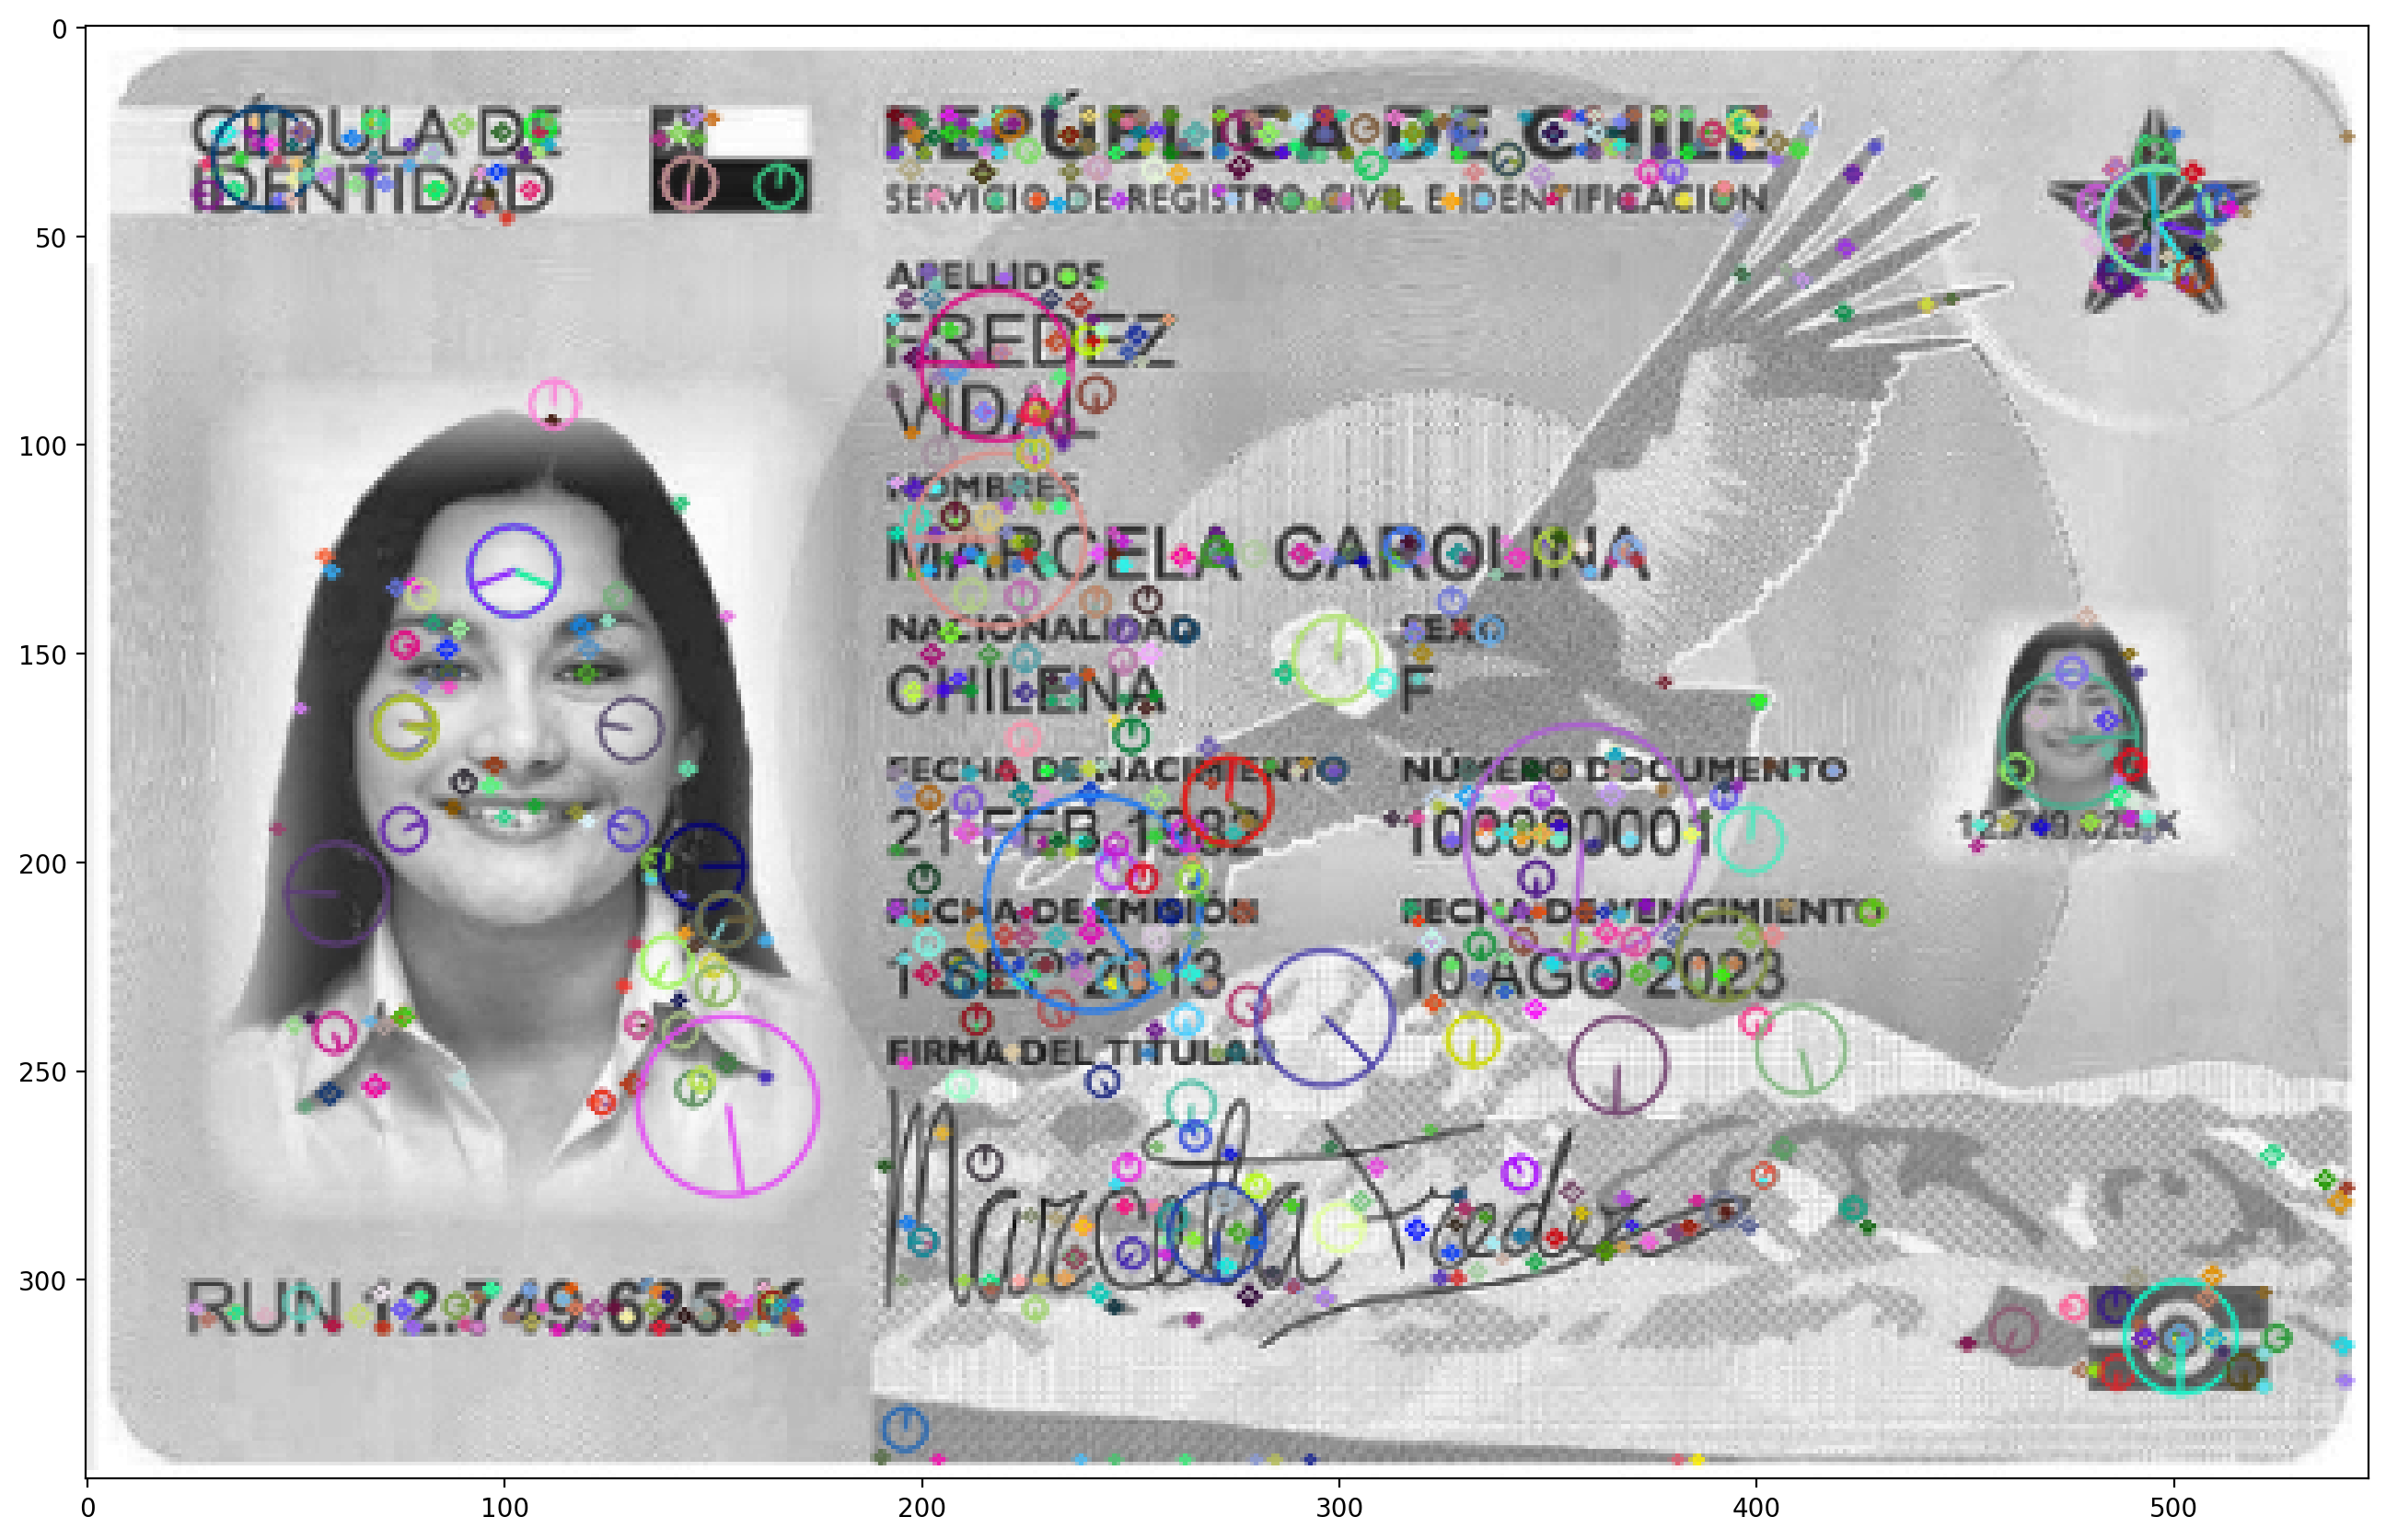

In [9]:
import cv2 
import matplotlib.pyplot as plt
%matplotlib inline

#reading image
#img1 = cv2.imread('El_ejemplo_de_Cedula_identidad_Chile_2013.jpg')  
#gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

#keypoints
sift = cv2.xfeatures2d.SIFT_create()
keypoints_1, descriptors_1 = sift.detectAndCompute(img_rgb,None)

#img_sift = cv2.drawKeypoints(rut_eq,keypoints_1,img_rgb)

img_sift=cv2.drawKeypoints(rut_eq, keypoints_1, img_rgb,
                      flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.figure(figsize=(16, 12), dpi=200)
plt.imshow(img_sift)

# Cálculo de la homografía

In [41]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
MIN_MATCH_COUNT = 10
#img1 = cv.imread('20221214_153703.jpg',0)          # queryImage
img1 = cv.imread('20221214_153726.jpg',0)          # queryImage
img2 = cv.imread('El_ejemplo_de_Cedula_identidad_Chile_2013.jpg',0) # trainImage

# Initiate SIFT detector
sift = cv.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)
# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

In [42]:
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv.findHomography(dst_pts, src_pts, cv.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    h,w = img2.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv.perspectiveTransform(pts,M)
    img1 = cv.polylines(img1,[np.int32(dst)],True,255,20, cv.LINE_AA)
else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

# Dibujar correspondencias

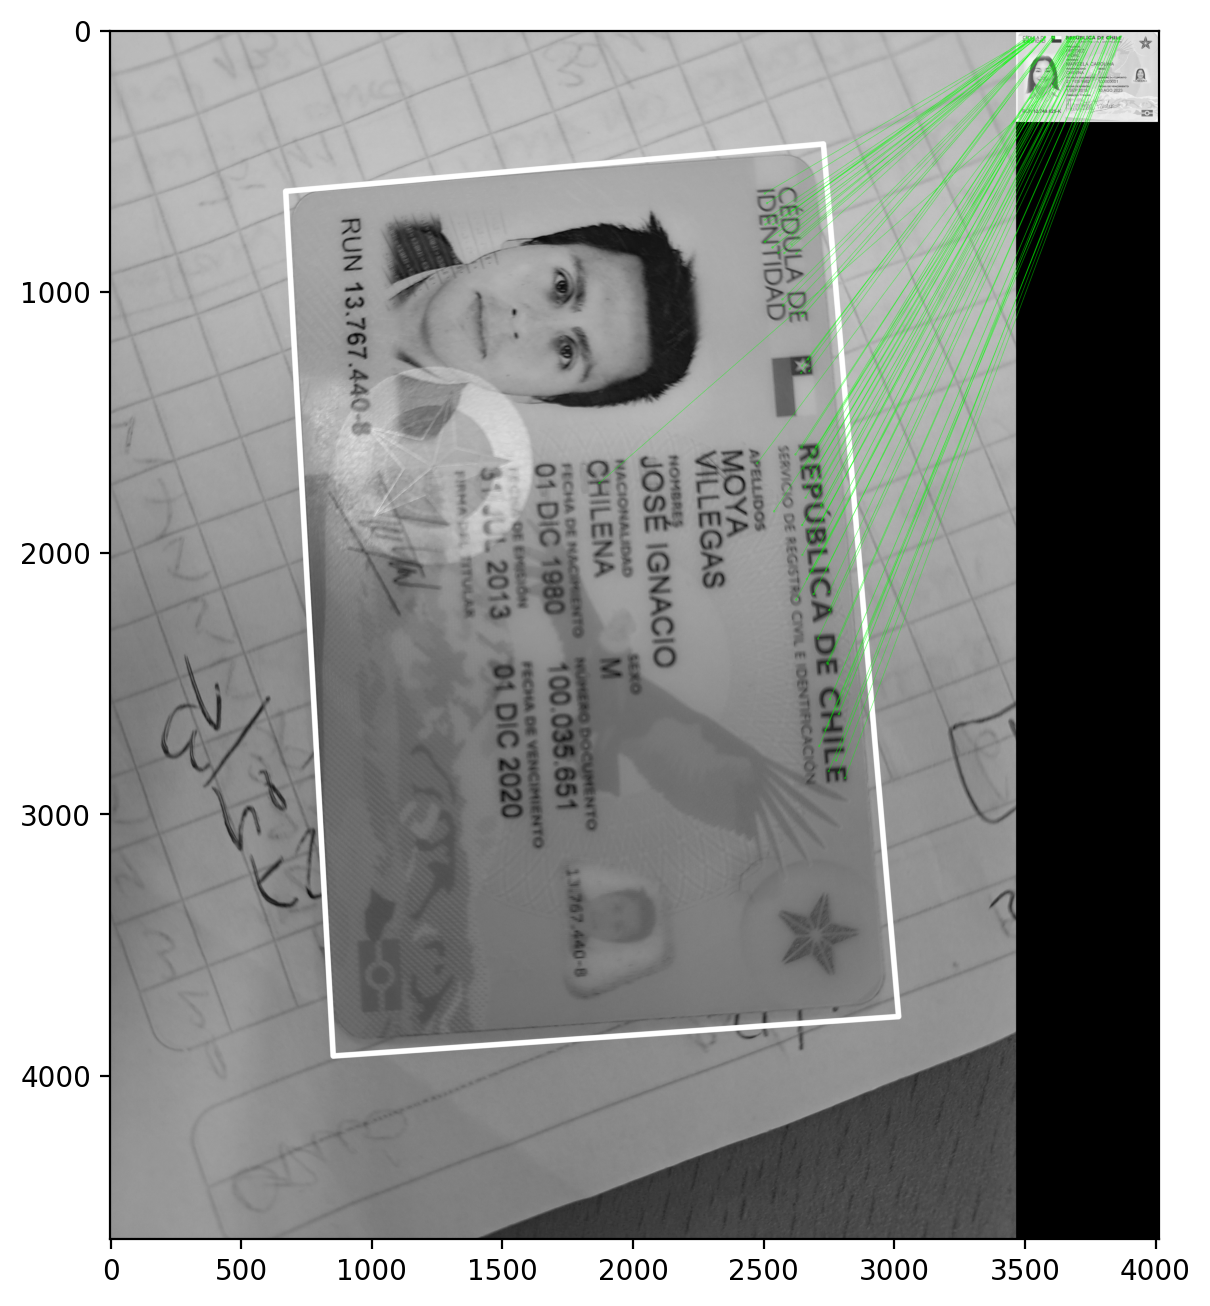

(<matplotlib.image.AxesImage at 0x7f9725a8f640>, None)

In [44]:
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
img3 = cv.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)

plt.figure(figsize=(10, 8), dpi=200)
plt.imshow(img3, 'gray'),plt.show()

# Indentificación de imágenes

Identificar si un cartnet es válido y está de frente.

Identificar si un carnet es válido y está del otro lado.

## Obtengo los descriptores de la imagen

Guardo las palabras visuales obtenidas del carnet de frente.

In [46]:
import numpy as np
import cv2 as cv
import pickle

img1 = cv.imread('El_ejemplo_de_Cedula_identidad_Chile_2013.jpg',cv.IMREAD_GRAYSCALE)   # Train image

# Crear el detecto SIFT 
sift = cv.SIFT_create()

# Guardo en un diccionario descriptores de mario 
kp1, des1 = sift.detectAndCompute(img1,None)

dic = {"frente": des1}

# Guardo en disco los descriptores
with open('mi-base-de-datos.pkl', 'wb') as f:
  pickle.dump(dic, f)


###Cargar los descriptores guardados

In [47]:
# Leo la matriz en el disco duro
with open('mi-base-de-datos.pkl', 'rb') as f:
  b = pickle.load(f)

desc_frente = b['frente']

### Pregunto si los descriptores pertenecen al carnet frontal

In [53]:
# Calculo los descriptores de la imagen nueva
# Inicializo el detector SIFT 

# Query Image
img_frente = cv.imread('20221214_153726.jpg',cv.IMREAD_GRAYSCALE)
img_no_frente = cv.imread('20221214_153707.jpg',cv.IMREAD_GRAYSCALE)

sift = cv.SIFT_create()

# Encuentro los descriptores de la imagen a revisar
kp1, des1 = sift.detectAndCompute(img_frente,None)

# Busco los descriptores que están más cerca
bf = cv.BFMatcher()
matches = bf.knnMatch(desc_frente, des1, k=2)

# Aplico test de cercanía
good = []
for m,n in matches:
    if m.distance < 0.5*n.distance:
        good.append([m])

coincidencias = len(good)
print(f'Número de coincidencia de descriptores: {coincidencias}')

if (coincidencias > 20):
  print('Carnet: Posición de frente')
else:
  print('No se reconoce carnet')

Número de coincidencia de descriptores: 38
Carnet: Posición de frente
